# Imports 

In [308]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import trapz
from scipy.optimize import linprog
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Import data

In [387]:
# train = pd.read_csv('data/train.csv')
# test = pd.read_csv('data/test.csv')
# sample_submission = pd.read_csv('data/sample_submission.csv')
train = pd.read_csv('gs://cytora-user-wout/train.csv')
test = pd.read_csv('gs://cytora-user-wout/test.csv')
sample_submission = pd.read_csv('gs://cytora-user-wout/sample_submission.csv')

# Data exploration

## Train

In [4]:
train.shape

(188318, 132)

In [5]:
cat_features = [feature for feature in list(train) if 'cat' in feature]
print('{} categorical features'.format(len(cat_features)))

cont_features = [feature for feature in list(train) if 'cont' in feature]
print('{} of continuous features: '.format(len(cont_features)))

116 categorical features
14 of continuous features: 


In [6]:
assert len(cat_features) + len(cont_features) + 2 == train.shape[1]

### Categorical features 

How many categories do the categorical features have? 

In [7]:
cat_nr_dict = {}

for cat in cat_features:
    cat_nr_dict[cat] = train[cat].nunique()

In [8]:
cat_nr_series = pd.Series(cat_nr_dict)

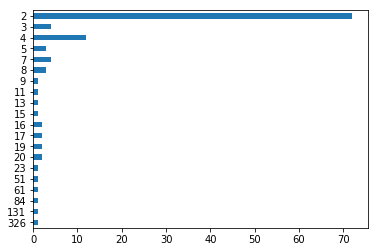

In [353]:
cat_nr_series.value_counts().sort_index(ascending=False).plot('barh');

In [10]:
for i in cat_nr_series.value_counts().sort_index()[-6:].index:
    
    perc = sum(train[cat_nr_series[cat_nr_series == i].index[0]].value_counts(normalize=1) < 0.01) / i

    print('Nr of categories: ', i)
    print('Perc of categories smaller than 1%: ', perc)
    print()

Nr of categories:  23
Perc of categories smaller than 1%:  0.5217391304347826

Nr of categories:  51
Perc of categories smaller than 1%:  0.5882352941176471

Nr of categories:  61
Perc of categories smaller than 1%:  0.5737704918032787

Nr of categories:  84
Perc of categories smaller than 1%:  0.9523809523809523

Nr of categories:  131
Perc of categories smaller than 1%:  0.8625954198473282

Nr of categories:  326
Perc of categories smaller than 1%:  0.9233128834355828



For some algorithms we need to create dummies from categorical variables, so we can cut off at categorgy being represented in $<1\%$ of the rows.

In [11]:
def to_other_cat(df, col, cut_off):
    df = df.copy()
    vc = df[col].value_counts(normalize=1)
    small_category = vc < cut_off
    small_category_list = list(small_category.index[small_category])
    small_category_filter = df[col].isin(small_category_list)
    df.loc[small_category_filter, col] = 'other'
    return df[col]

In [13]:
cut_off = 0.01

for feat in cat_features:
    train[feat + '_o'] = to_other_cat(train, feat, 0.01)
    
    # we need to ensure the same categories exist in the test set for when we make predictions
    test[feat + '_o'] = test[feat]
    
    keep_list = list(set(train[feat + '_o']))

    test.loc[~test[feat].isin(keep_list), feat + '_o'] = 'other'

In [14]:
cat_other_features = [feat for feat in list(train) if '_o' in feat]

In [15]:
cat_dummy_features = []

for feat in cat_other_features:
    train_dummy_df = pd.get_dummies(train[feat], prefix=feat, drop_first=True)
    
    dummy_features = list(train_dummy_df)
    
    train[dummy_features] = train_dummy_df
    
    cat_dummy_features = cat_dummy_features + dummy_features
    
    test_dummy_df = pd.get_dummies(test[feat], prefix=feat)
    
    test[dummy_features] = test_dummy_df[dummy_features]

In [16]:
assert set(list(test)) - set(list(train)) == set()

In [17]:
assert set(list(train)) - set(list(test)) == {'loss'}

The cat_dummy_features should all be boolean now

In [18]:
assert (train[cat_dummy_features].dtypes == 'uint8').all()

Random slice of the categoricals:

In [19]:
train[cat_dummy_features].sample(5).T.sample(5).T

,cat2_o_B,cat111_o_G,cat113_o_AX,cat112_o_AV,cat116_o_LM
99542,0,0,0,0,0
50898,0,0,0,0,0
156869,0,0,0,0,0
138433,0,0,0,0,0
158254,1,0,0,0,0


### Continuous features 

''

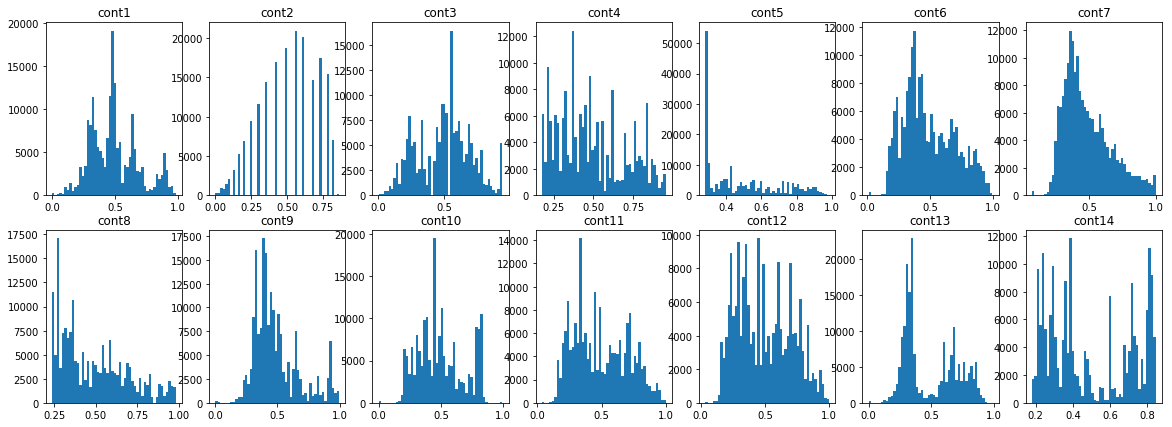

In [20]:
fig, ax = plt.subplots(ncols=7, nrows=2, figsize=(20, 7))

k=0
for j in range(2):
    for i in range(7):
        ax[j,i].hist(train[cont_features[k]], bins=50)
        ax[j,i].set_title(cont_features[k])
        k+=1
;

Maybe cont2 can be changed to categorical variable.

In [21]:
c2_un = train['cont2'].nunique()
print('Cont2 has {} unique elements'.format(c2_un))

Cont2 has 33 unique elements


Hard to determine without context on what the variable represents, might be something like age in which case continuous makes sense. 

### Target variable

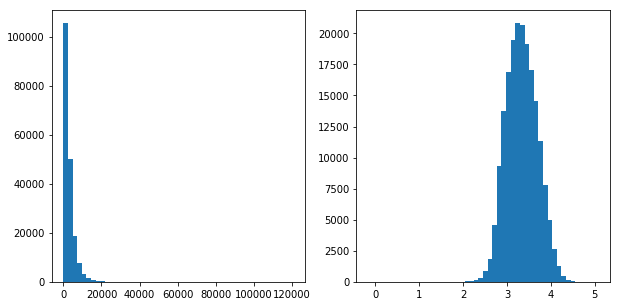

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].hist(train['loss'], bins=50);
ax[1].hist(np.log10(train['loss']), bins=50);

## Test +  sample submission

In [24]:
test.shape

(125546, 588)

In [25]:
sample_submission.shape

(125546, 2)

In [26]:
assert pd.Series(test['id'] == sample_submission['id']).all()

# Evaluation

Let's define a Lorenz curve 

In [398]:
def lorenz_curve(risk_proxy, loss):
    idx = np.argsort(risk_proxy)
    
    ordered_loss = loss[idx]
    cum_loss =  ordered_loss.cumsum() / sum(loss)
    x_axis = np.linspace(0,1,len(cum_loss))
    
    return np.append([0], x_axis), np.append([0], cum_loss)

In [399]:
def score(x, y):
    integral = trapz(y, x)
    output = 1 - 2 * integral 
    
    return output

In [459]:
def lorenz_plot(df, list_of_risk_proxies, loss):
    
    fig, ax = plt.subplots(figsize=(10,10))
    for i in range(len(list_of_risk_proxies)):
        y = lorenz_curve(df[list_of_risk_proxies[i]].values, df[loss].values)
        score_y = score(y[0], y[1])
        
        legend = list_of_risk_proxies[i] + ', score: ' + str(np.round(score_y,2))
        
        ax.plot(y[0], y[1], label=legend);
        
    ax.set_xlim(0,1.01)
    ax.set_ylim(0,1.01)
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.legend()

In [396]:
thing = pd.DataFrame({
    'x1': np.array([0,7,2,7,4,5]), 
    'x2': np.array([10,1,2,3,4,5]),
    'x3': np.array([0,1,3,2,4,0]),
    'x4': np.array([0,10,8,1,5,3]),
    'loss':np.array([1,2,5,66,9,4])
})

In [436]:
np.random.randint(100)

26

In [440]:
thing = pd.DataFrame({
    'x1': np.random.rand(1,10)[0] * np.random.randint(10000), 
    'x2': np.random.rand(1,10)[0] * np.random.randint(10000),
    'x3': np.random.rand(1,10)[0] * np.random.randint(10000),
    'x4': np.random.rand(1,10)[0] * np.random.randint(10000),
    'loss': np.random.rand(1,10)[0] * np.random.randint(10000)
#     'loss':np.array([11,3,2,5,66,9,4,5,7,3])
})

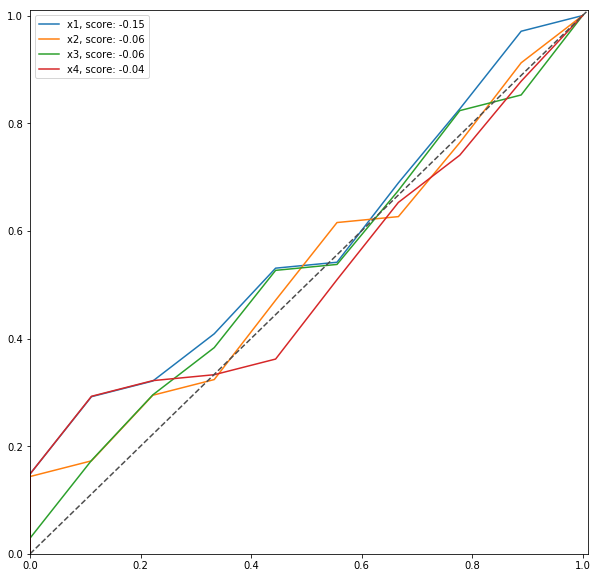

In [460]:
lorenz_plot(
    thing,
    ['x1', 'x2', 'x3', 'x4'],
    'loss'   
)

# RMSE 

# Process for modelling

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop('loss', axis=1),
    train[['loss']],
    test_size=0.33, 
    random_state=42
)

In [34]:
X_train.head(2)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cat116_o_HX,cat116_o_IE,cat116_o_IG,cat116_o_KW,cat116_o_LB,cat116_o_LM,cat116_o_LN,cat116_o_LO,cat116_o_MD,cat116_o_other
31228,98041,A,A,A,B,A,A,A,A,A,...,0,0,0,0,0,0,0,0,0,0
75562,236254,B,A,A,A,A,B,A,A,A,...,0,0,0,0,0,0,0,0,0,0


In [35]:
y_train.head(2)

,loss
31228,840.33
75562,1303.28


# GLM

In [36]:
assert X_train[cat_dummy_features + cont_features].notnull().all().all()

In [75]:
def train_glm(df, target, feature_list, output='results'):
    glm = smf.GLM(
        exog=sm.add_constant(df[feature_list]).astype(float).values,
        endog=target.astype(float).values,
        family=sm.families.Gamma(),
    )

    results_glm = glm.fit()
    

    if output == 'results':
        return results_glm.summary2(xname=['const'] + list(df[feature_list]))
    if output == 'model':
        return glm, results_glm

In [46]:
results_continuous = train_glm(X_train, y_train, cont_features)

In [47]:
results_continuous

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
==================================================================
Model:              GLM              AIC:            2256545.6809 
Link Function:      inverse_power    BIC:            -1401931.0934
Dependent Variable: y                Log-Likelihood: -1.1283e+06  
Date:               2019-05-23 07:35 LL-Null:        -1.1312e+06  
No. Observations:   126173           Deviance:       79846.       
Df Model:           14               Pearson chi2:   9.43e+04     
Df Residuals:       126158           Scale:          0.74763      
Method:             IRLS                                          
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const      0.0005     0.0000    83.9685   0.0000    0.0005    0.0005
cont1      0.0002     0.0000    14.2305   0.0000    0.0002    0.0002
cont2     -0.0002     0.0000   -40.7400   0.0000   -0.0002   -0.0002
cont3      0.0000     0.0000     0.0685   0.9454   -0.0000    0.0000
cont4      0.0000     0.0000     7.4573   0.0000    0.0000    0.0001
cont5     -0.0000     0.0000    -2.1149   0.0344   -0.0000   -0.0000
cont6      0.0000     0.0000     2.3404   0.0193    0.0000    0.0001
cont7     -0.0001     0.0000   -16.4038   0.0000   -0.0002   -0.0001
cont8     -0.0000     0.0000    -6.4799   0.0000   -0.0000   -0.0000
cont9     -0.0002     0.0000   -13.6724   0.0000   -0.0002   -0.0002
cont10     0.0000     0.0000     2.2026   0.0276    0.0000    0.0000
cont11     0.0001     0.0000     3.3029   0.0010    0.0000    0.0002
cont12    -0.0002     0.0000    -5.7861   0.0000   -0.0003   -0.0001
cont13     0.0000     0.0000     5.0341   0.0000    0.0000    0.0001
cont14    -0.0000     0.0000    -7.8635   0.0000   -0.0000   -0.0000
==================================================================

"""

In [52]:
results_continuous_significance = results_continuous.tables[1]['P>|z|']
continuous_significant_features = list(results_continuous_significance[results_continuous_significance<0.05].index)

In [54]:
categorical_significant_features = []

In [55]:
for i in range(0, len(cat_features)):
    temp_dummy_feature_list = [dummy_cat for dummy_cat in cat_dummy_features if cat_features[i] + '_o' in dummy_cat]
    temp_res = train_glm(X_train, y_train, temp_dummy_feature_list)
    temp_significance = temp_res.tables[1].loc[temp_dummy_feature_list, 'P>|z|']
    categorical_significant_features = categorical_significant_features + list(temp_significance[temp_significance < 0.05].index)

In [64]:
significant_features = [x for x in categorical_significant_features + continuous_significant_features if 'const' not in x]

In [76]:
glm, results_glm = train_glm(
    X_train,
    y_train,
    significant_features,
    output='model'
)

In [223]:
pred_glm = glm.predict(
    exog=sm.add_constant(X_test[significant_features]).astype(float).values,
    params=results_glm.params, 
)

# TODO: why are there negative values

In [95]:
comparison.head(5)

,pred,y_test
92922,1320.061365,5.25
55422,1780.038411,8.40
40351,1613.858451,20.11
110722,2074.024340,21.00
51671,2086.644977,34.26


In [96]:
comparison.tail(5)

,pred,y_test
118666,-3683.043332,51127.50
13030,2727.584635,51383.04
113176,7062.159133,59826.79
125668,-7146.472185,67537.73
172883,50351.729325,79623.52


### Results

In [182]:
def rmse(y_test, pred):
    return np.sqrt(mean_squared_error(y_test, pred))

In [183]:
rmse(y_test, pred)

231685.31722080102

In [98]:
test['pred_glm'] = glm.predict(
    exog=sm.add_constant(test[significant_features]).astype(float).values,
    params=results_glm.params, 
)


# XGB

Parameters

In [216]:
params = {
    'objective': 'reg:gamma',
    'max_depth': 4,
    'eta': 0.2,
    'eval_metric': 'gamma-nloglik',
    'nthread': os.cpu_count() - 1,
    'silent': True,
    'booster': 'gbtree',
    'colsample_bytree': 1,
    'gamma': 0,
    'max_delta_step': 0,
    'min_child_weight': 1,
    'subsample': 1,
}



In [217]:
def train_xgb(X_train, y_train, feature_list, params):
    
    num_boost_round = 1000
    cv_folds = 5
    early_stopping_rounds = 10
    early_stopping_cv_folds = 5
    verbose_eval = 10
    early_stopping_cv_fold_seed = 42
    
    X = X_train[feature_list].values
    y = y_train.values
    
    D_train = xgb.DMatrix(
        data=X,
        label=y,
        feature_names=feature_list,
        missing=np.nan, 
    )
    
    results = xgb.cv(
        params=params,
        dtrain=D_train,
        num_boost_round=num_boost_round,
        early_stopping_rounds=early_stopping_rounds,
        nfold=early_stopping_cv_folds,
        as_pandas=True,
        verbose_eval=verbose_eval,
        seed=early_stopping_cv_fold_seed
    )
    
    opt_num_boost_round = len(results)

    bst = xgb.train(
        params=params,
        dtrain=D_train,
        num_boost_round=opt_num_boost_round,
    )
    
    return bst

In [218]:
booster = train_xgb(X_train, y_train, cont_features + cat_dummy_features, params)

[0]	train-gamma-nloglik:4970.88+8.4941	test-gamma-nloglik:4970.88+33.9785
[10]	train-gamma-nloglik:675.089+1.1495	test-gamma-nloglik:675.09+4.60371
[20]	train-gamma-nloglik:95.4364+0.155579	test-gamma-nloglik:95.4364+0.625583
[30]	train-gamma-nloglik:18.6477+0.0211377	test-gamma-nloglik:18.6483+0.0870741
[40]	train-gamma-nloglik:9.58495+0.00331268	test-gamma-nloglik:9.58537+0.0152475
[50]	train-gamma-nloglik:8.8968+0.00156116	test-gamma-nloglik:8.89765+0.0064399
[60]	train-gamma-nloglik:8.85441+0.00159023	test-gamma-nloglik:8.8558+0.00571917
[70]	train-gamma-nloglik:8.84261+0.00158166	test-gamma-nloglik:8.84459+0.00579387
[80]	train-gamma-nloglik:8.83677+0.00167166	test-gamma-nloglik:8.83935+0.00580396
[90]	train-gamma-nloglik:8.83338+0.00180796	test-gamma-nloglik:8.83646+0.00580748
[100]	train-gamma-nloglik:8.83099+0.00183094	test-gamma-nloglik:8.8346+0.00584976
[110]	train-gamma-nloglik:8.82919+0.00173921	test-gamma-nloglik:8.83331+0.00601651
[120]	train-gamma-nloglik:8.82769+0.00174

In [227]:
D_test = xgb.DMatrix(    
    data=X_test[cont_features + cat_dummy_features].values,
    feature_names= cont_features + cat_dummy_features,
    missing=np.nan, 
)

pred_xgb = booster.predict(D_test)

In [229]:
rmse(pred_xgb, y_test)

1892.6111022663472

In [269]:
D_test_final = xgb.DMatrix(    
    data=test[cont_features + cat_dummy_features].values,
    feature_names= cont_features + cat_dummy_features,
    missing=np.nan, 
)

In [337]:
test['pred_xgb'] = booster.predict(D_test_final)

# Random Forest

In [266]:
rf = RandomForestRegressor()

In [268]:
rf.fit(X_train[cont_features + cat_dummy_features], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [271]:
pred_rf = rf.predict(X_test[cont_features + cat_dummy_features])

In [272]:
comparison['pred_rf'] = pred_rf

In [273]:
rmse(pred_rf, y_test)

2071.159251313066

In [338]:
test['pred_rf'] = rf.predict(test[cont_features + cat_dummy_features])

# Ensemble

In [299]:
comparison = pd.DataFrame({
    'y_test': y_test['loss'],
    'pred_glm': pred,
    'pred_rf': pred_rf,
    'pred_xgb': pred_xgb,
    
}).sort_values('y_test')

In [305]:
comparison['rf_xgb_ens'] = 0.2 * comparison['pred_rf'] + 0.8 * comparison['pred_xgb']

In [304]:
rmse(comparison['pred_xgb'], comparison['y_test'])

1892.6111022663474

In [306]:
rmse(comparison['rf_xgb_ens'], comparison['y_test'])

1884.7986343138743

Finding the optimal weights

In [335]:
smallest_rmse = np.inf

lin_space = np.linspace(0,1,11)

for z in lin_space:
    for y in lin_space:
        for x in lin_space:
            if x + y + z == 1:
                x = np.round(x,1)
                y = np.round(y,1)
                z = np.round(z,1)
                
                comparison['optimal_stack_ensemble'] = x * comparison['pred_glm'] + y * comparison['pred_xgb'] + z * comparison['pred_rf']
                
                previous_rmse = smallest_rmse
                current_rmse = rmse(comparison['optimal_stack_ensemble'], comparison['y_test'])
                
                if current_rmse < smallest_rmse:
                    smallest_rmse = current_rmse
                    print('Optimal weights: {} with rmse {}'.format((x,y,z), smallest_rmse))
                    comparison['optimal_stack_ensemble'] = x * comparison['pred_glm'] + y * comparison['pred_xgb'] + z * comparison['pred_rf']
                
#                 print(x, y, z)


Optimal weights: (1.0, 0.0, 0.0) with rmse 231685.317220801
Optimal weights: (0.9, 0.1, 0.0) with rmse 208515.05194858552
Optimal weights: (0.8, 0.2, 0.0) with rmse 185345.00139176997
Optimal weights: (0.7, 0.3, 0.0) with rmse 162175.25758004538
Optimal weights: (0.6, 0.4, 0.0) with rmse 139005.97389907457
Optimal weights: (0.5, 0.5, 0.0) with rmse 115837.42644916964
Optimal weights: (0.4, 0.6, 0.0) with rmse 92670.16743227793
Optimal weights: (0.3, 0.7, 0.0) with rmse 69505.48521642639
Optimal weights: (0.2, 0.8, 0.0) with rmse 46347.24368901578
Optimal weights: (0.1, 0.9, 0.0) with rmse 23214.725884474803
Optimal weights: (0.0, 1.0, 0.0) with rmse 1892.6111022663474
Optimal weights: (0.0, 0.9, 0.1) with rmse 1885.8765488968004
Optimal weights: (0.0, 0.8, 0.2) with rmse 1884.7986343138743


### Predicting which model to use

In [409]:
comparison[
    ['pred_glm', 'pred_rf', 'pred_xgb', 'optimal_stack_ensemble', 'y_test']
].describe().T

,count,mean,std,min,25%,50%,75%,max
pred_glm,62145.0,3774.394407,231741.280956,-1.849444e+07,1768.682225,2205.659934,3026.313478,4.951430e+07
pred_rf,62145.0,3072.835961,2234.883935,2.782340e+02,1631.317000,2413.441000,3768.119000,9.145020e+04
pred_xgb,62145.0,3004.416748,2237.456543,4.823224e+02,1600.835693,2276.151367,3617.894043,6.622472e+04
optimal_stack_ensemble,62145.0,3072.835961,2234.883935,2.782340e+02,1631.317000,2413.441000,3768.119000,9.145020e+04
y_test,62145.0,3040.200847,2880.910445,5.250000e+00,1205.490000,2117.700000,3887.870000,7.962352e+04


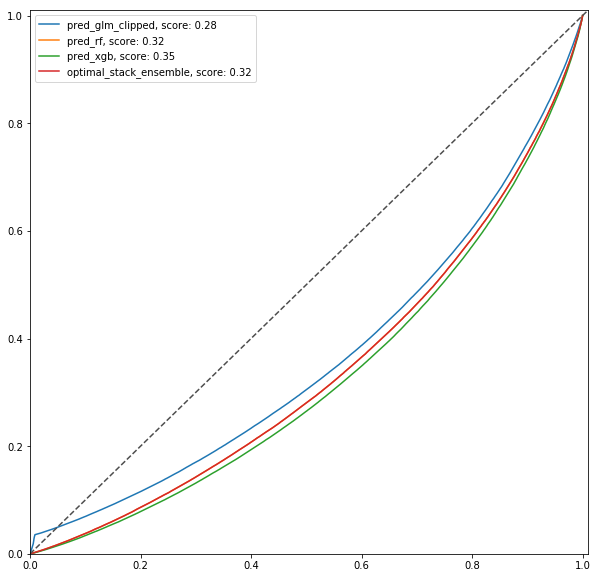

In [468]:
lorenz_plot(
    comparison,
    ['pred_glm', 'pred_rf', 'pred_xgb', 'optimal_stack_ensemble'],
    'y_test'   
)

In [291]:
comparison = pd.DataFrame({
    'pred_glm': pred,
    'y_test': y_test['loss']
}).sort_values('y_test')

# Shap values

In [469]:
import shap

In [471]:
explainer = shap.TreeExplainer(booster)

In [472]:
shap_values = explainer.shap_values(X_test[cont_features + cat_dummy_features])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test[cont_features + cat_dummy_features])

This is not the most exciting when you don't know what the features represent

# Results 

In [340]:
test['optimal_stack_ensemble'] = 0.8 * test['pred_xgb'] + 0.2 * test['pred_rf']

In [343]:
sample_submission['loss'] = test['optimal_stack_ensemble']